# downloads

In [1]:
!pip install streamlit pyngrok

# Necessary Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import subprocess
import threading

# Directory Mandatory !

In [1]:
import os
os.makedirs("data/input", exist_ok=True)
os.makedirs("data/output", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("text", exist_ok=True)

# Loading and basic stats

In [3]:
# Load the CSV files (update paths if needed, e.g., '/content/drive/MyDrive/email_table.csv')
email_table = pd.read_csv('/content/data/input/email_table.csv')
email_opened_table = pd.read_csv('/content/data/input/email_opened_table.csv')
link_clicked_table = pd.read_csv('/content/data/input/link_clicked_table.csv')

# Display first few rows to inspect
print("Email Table Head:")
print(email_table.head())
print("\nEmail Opened Table Head:")
print(email_opened_table.head())
print("\nLink Clicked Table Head:")
print(link_clicked_table.head())

# Merge tables
# Step 1: Merge email_table with email_opened_table
email_table['opened'] = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)

# Step 2: Merge with link_clicked_table
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

# Rename merged dataframe for clarity
merged_df = email_table.copy()

# Basic data checks
print("\nMerged DataFrame Info:")
print(merged_df.info())
print("\nMissing Values:")
print(merged_df.isnull().sum())
print("\nBasic Stats:")
print(merged_df.describe(include='all'))

# Check unique values for categorical columns
categorical_cols = ['email_text', 'email_version', 'weekday', 'user_country']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(merged_df[col].value_counts())

# Save merged dataset for EDA
merged_df.to_csv('/content/data/output/merged_email_data.csv', index=False)
print("\nMerged dataset saved as 'merged_email_data.csv'")


Email Table Head:
   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  
4                    6  

Email Opened Table Head:
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034

Link Clicked Table Head:
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------         

print(merged_email_data.head())

In [4]:
merged_df=pd.read_csv('/content/data/output/merged_email_data.csv')
merged_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


# EDA

Total Emails: 100000
Open Rate: 10.35%
Click-Through Rate (CTR): 2.12%

Open and Click Rates by email_text:
             Open Rate (%)  CTR (%)
email_text                         
long_email            9.12     1.85
short_email          11.59     2.39

Open and Click Rates by email_version:
               Open Rate (%)  CTR (%)
email_version                        
generic                 7.93     1.51
personalized           12.78     2.73

Open and Click Rates by weekday:
           Open Rate (%)  CTR (%)
weekday                          
Friday              7.41     1.40
Monday             11.61     2.29
Saturday            8.77     1.78
Sunday              8.76     1.68
Thursday           11.84     2.44
Tuesday            12.05     2.49
Wednesday          12.03     2.76

Open and Click Rates by user_country:
              Open Rate (%)  CTR (%)
user_country                        
ES                     3.91     0.83
FR                     4.06     0.80
UK                    12.02  

<ipython-input-5-0c3526d02aa9>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_rates = df.groupby('hour_bin').agg({
<ipython-input-5-0c3526d02aa9>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_rates = df.groupby('purchase_bin').agg({


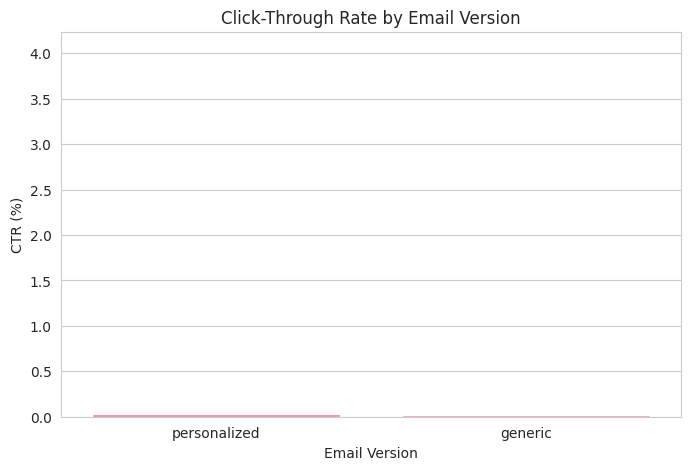

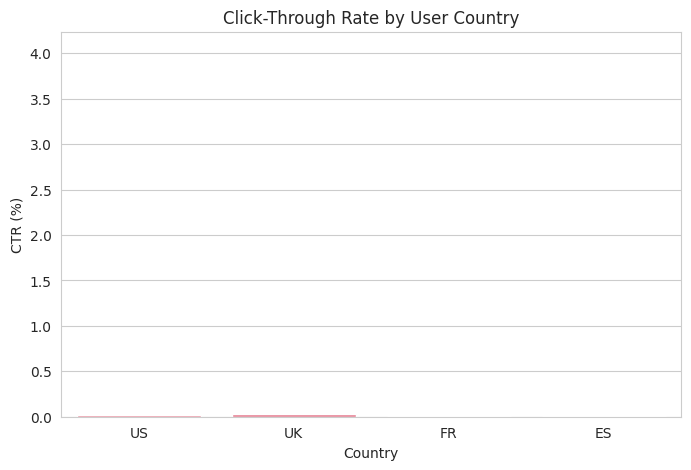

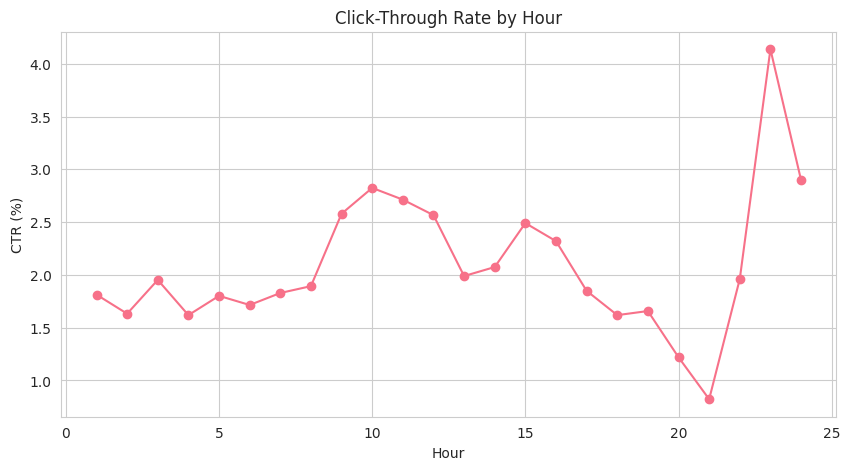

<ipython-input-5-0c3526d02aa9>:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values='clicked', index='weekday', columns='hour_bin', aggfunc='mean') * 100


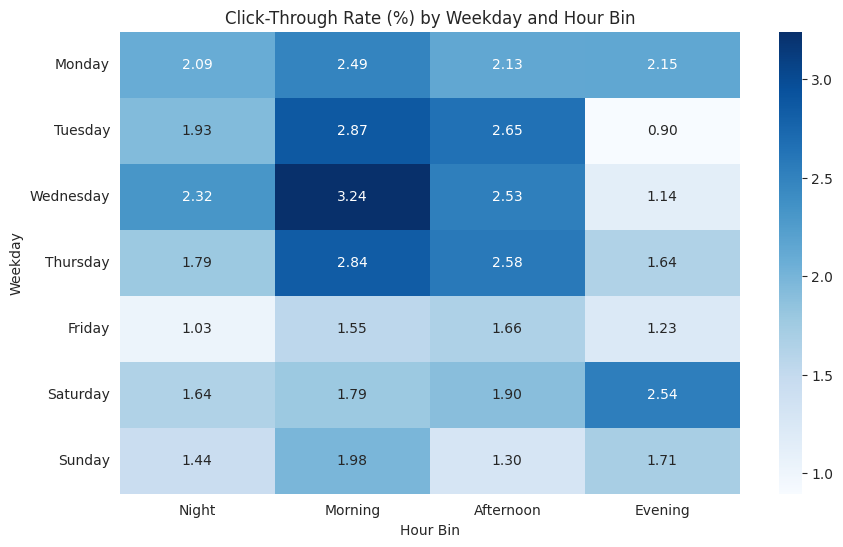


Saved segment_rates.csv, hour_rates.csv, purchase_rates.csv for reporting
Saved plots: ctr_email_version.png, ctr_user_country.png, ctr_hour.png, ctr_weekday_hour_heatmap.png


In [5]:
# Set Seaborn style (replaces plt.style.use('seaborn'))
sns.set_style('whitegrid')
sns.set_palette('husl')

# Load merged dataset
try:
    df = pd.read_csv('/content/data/output/merged_email_data.csv')
except FileNotFoundError:
    print("Error: 'merged_email_data.csv' not found. Ensure the file is in your Colab directory.")
    raise

# 1. Calculate open rate and click-through rate (CTR)
total_emails = len(df)
open_rate = df['opened'].mean() * 100
ctr = df['clicked'].mean() * 100
print(f"Total Emails: {total_emails}")
print(f"Open Rate: {open_rate:.2f}%")
print(f"Click-Through Rate (CTR): {ctr:.2f}%")

# 2. Segment analysis: Open and click rates by key columns
segments = ['email_text', 'email_version', 'weekday', 'user_country']
for seg in segments:
    print(f"\nOpen and Click Rates by {seg}:")
    rates = df.groupby(seg).agg({
        'opened': 'mean',
        'clicked': 'mean'
    }) * 100  # Convert to percentages
    rates = rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
    print(rates.round(2))

# Special case: Hour (bin for smoother trends)
df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
print("\nOpen and Click Rates by Hour Bin:")
hour_rates = df.groupby('hour_bin').agg({
    'opened': 'mean',
    'clicked': 'mean'
}) * 100
hour_rates = hour_rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
print(hour_rates.round(2))

# Special case: Past purchases (bin for interpretability)
df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                           labels=['0', '1-2', '3-5', '6-10', '11+'])
print("\nOpen and Click Rates by Past Purchases Bin:")
purchase_rates = df.groupby('purchase_bin').agg({
    'opened': 'mean',
    'clicked': 'mean'
}) * 100
purchase_rates = purchase_rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
print(purchase_rates.round(2))

# 3. Visualizations
# CTR by email_version
plt.figure(figsize=(8, 5))
sns.barplot(x='email_version', y='clicked', data=df, errorbar=None)
plt.title('Click-Through Rate by Email Version')
plt.ylabel('CTR (%)')
plt.xlabel('Email Version')
plt.ylim(0, df['clicked'].mean() * 100 * 2)  # Scale for visibility
plt.savefig('/content/images/ctr_email_version.png')
plt.show()

# CTR by user_country
plt.figure(figsize=(8, 5))
sns.barplot(x='user_country', y='clicked', data=df, errorbar=None)
plt.title('Click-Through Rate by User Country')
plt.ylabel('CTR (%)')
plt.xlabel('Country')
plt.ylim(0, df['clicked'].mean() * 100 * 2)
plt.savefig('/content/images/ctr_user_country.png')
plt.show()

# CTR by hour (line plot for trend)
hour_trend = df.groupby('hour')['clicked'].mean() * 100
plt.figure(figsize=(10, 5))
hour_trend.plot(kind='line', marker='o')
plt.title('Click-Through Rate by Hour')
plt.ylabel('CTR (%)')
plt.xlabel('Hour')
plt.grid(True)
plt.savefig('/content/images/ctr_hour.png')
plt.show()

# Heatmap: CTR by weekday and hour_bin
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = df.pivot_table(values='clicked', index='weekday', columns='hour_bin', aggfunc='mean') * 100
pivot = pivot.reindex(weekday_order)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='Blues')
plt.title('Click-Through Rate (%) by Weekday and Hour Bin')
plt.xlabel('Hour Bin')
plt.ylabel('Weekday')
plt.savefig('/content/images/ctr_weekday_hour_heatmap.png')
plt.show()

# 4. Save results for reporting
rates.to_csv('/content/data/output/segment_rates.csv', index=True)
hour_rates.to_csv('/content/data/output/hour_rates.csv', index=True)
purchase_rates.to_csv('/content/data/output/purchase_rates.csv', index=True)
print("\nSaved segment_rates.csv, hour_rates.csv, purchase_rates.csv for reporting")
print("Saved plots: ctr_email_version.png, ctr_user_country.png, ctr_hour.png, ctr_weekday_hour_heatmap.png")

#Model Building for Click Prediction

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Set random seed for reproducibility
np.random.seed(42)

# Load merged dataset
try:
    df = pd.read_csv('/content/data/output/merged_email_data.csv')
except FileNotFoundError:
    print("Error: 'merged_email_data.csv' not found. Ensure file is in Colab directory.")
    raise

# 1. Feature Engineering
# Drop email_id (not predictive)
df = df.drop('email_id', axis=1)

# Encode categorical variables
le = LabelEncoder()
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df[col] = le.fit_transform(df[col])

# Bin hour for smoother trends (from EDA)
df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                        labels=['Night', 'Morning', 'Afternoon', 'Evening'])
df['hour_bin'] = le.fit_transform(df['hour_bin'])

# Bin user_past_purchases for interpretability
df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                           labels=['0', '1-2', '3-5', '6-10', '11+'])
df['purchase_bin'] = le.fit_transform(df['purchase_bin'])

# Drop original hour and user_past_purchases (use binned versions)
df = df.drop(['hour', 'user_past_purchases'], axis=1)

# Define features (X) and target (y)
X = df.drop(['clicked', 'opened'], axis=1)  # Exclude opened (not known at send time)
y = df['clicked']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Model Training
# Random Forest with class weights to handle imbalance
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train model
model.fit(X_train, y_train)

# 4. Model Evaluation
# Predict probabilities and labels
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Cross-validation AUC
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-Validation AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 5. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.round(4))

# 6. Save Model and Feature Importance
joblib.dump(model, '/content/models/click_prediction_model.pkl')
feature_importance.to_csv('/content/data/output/feature_importance.csv', index=False)
print("\nSaved click_prediction_model.pkl and feature_importance.csv")


Model Performance on Test Set:
AUC-ROC: 0.7200
Precision: 0.0382
Recall: 0.6368
F1-Score: 0.0721

Cross-Validation AUC-ROC: 0.7161 (+/- 0.0182)

Feature Importance:
         Feature  Importance
5   purchase_bin      0.4365
2        weekday      0.1850
3   user_country      0.1557
4       hour_bin      0.0927
1  email_version      0.0865
0     email_text      0.0436

Saved click_prediction_model.pkl and feature_importance.csv


# 4. Model Evaluation & CTR Improvement Estimation

In [7]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from scipy.stats import ttest_ind

# Set random seed for reproducibility
np.random.seed(42)

# Load merged dataset
try:
    df = pd.read_csv('/content/data/output/merged_email_data.csv')
except FileNotFoundError:
    print("Error: 'merged_email_data.csv' not found. Ensure file is in Colab directory.")
    raise

# Load trained model
try:
    model = joblib.load('/content/models/click_prediction_model.pkl')
except FileNotFoundError:
    print("Error: 'click_prediction_model.pkl' not found. Run Phase 3 script first.")
    raise

# 1. Feature Engineering (same as Phase 3)
df = df.drop('email_id', axis=1)
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df[col] = df[col].astype('category').cat.codes
df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                        labels=['Night', 'Morning', 'Afternoon', 'Evening']).cat.codes
df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                           labels=['0', '1-2', '3-5', '6-10', '11+']).cat.codes
df = df.drop(['hour', 'user_past_purchases'], axis=1)

# Define features (X) and target (y)
X = df.drop(['clicked', 'opened'], axis=1)
y = df['clicked']

# Train-test split (same as Phase 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Model Evaluation
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 3. CTR Improvement Estimation
# Current CTR (from EDA)
current_ctr = y.mean() * 100  # ~2.12%
print(f"\nCurrent CTR: {current_ctr:.2f}%")

# Simulate targeting top 20% of users by predicted probability
test_df = X_test.copy()
test_df['true_click'] = y_test
test_df['pred_proba'] = y_pred_proba
test_df = test_df.sort_values('pred_proba', ascending=False)
top_20_percent = int(0.2 * len(test_df))
targeted_users = test_df.head(top_20_percent)
new_ctr = targeted_users['true_click'].mean() * 100
ctr_lift = ((new_ctr - current_ctr) / current_ctr) * 100

print(f"New CTR (Top 20% Targeted): {new_ctr:.2f}%")
print(f"Estimated CTR Lift: {ctr_lift:.2f}%")

# 4. A/B Test Plan
ab_test_plan = """
A/B Test Plan for Model Validation
Objective: Compare model-driven email targeting vs. random targeting to validate CTR improvement.
Methodology:
- Group A (Control): Randomly select 10,000 users and send emails (current approach).
- Group B (Test): Use model to select 10,000 users with highest predicted click probabilities.
- Email Content: Use same email version (e.g., short_email, personalized) for both groups.
- Timing: Send emails at same time (e.g., 10 AM Tuesday, per EDA).
- Duration: Run for 1-2 weeks to collect sufficient click data.
- Metric: Measure CTR (# clicks / # emails sent) for both groups.
- Statistical Test: Use two-sample t-test to compare CTRs (significance level: 0.05).
Expected Outcome: Group B should show higher CTR (e.g., 3-4% vs. 2.12%).
Risks: Ensure groups are balanced (e.g., similar user_country distribution).
"""
print("\nA/B Test Plan:")
print(ab_test_plan)

# 5. Save Results
results = pd.DataFrame({
    'Metric': ['AUC-ROC', 'Precision', 'Recall', 'F1-Score', 'Current CTR (%)', 'New CTR (%)', 'CTR Lift (%)'],
    'Value': [auc, precision, recall, f1, current_ctr, new_ctr, ctr_lift]
})
results.to_csv('/content/data/output/model_evaluation_results.csv', index=False)
with open('/content/text/ab_test_plan.txt', 'w') as f:
    f.write(ab_test_plan)
print("\nSaved model_evaluation_results.csv and ab_test_plan.txt")


Model Performance on Test Set:
AUC-ROC: 0.6591
Precision: 0.0312
Recall: 0.4269
F1-Score: 0.0582

Current CTR: 2.12%
New CTR (Top 20% Targeted): 3.35%
Estimated CTR Lift: 58.09%

A/B Test Plan:

A/B Test Plan for Model Validation
Objective: Compare model-driven email targeting vs. random targeting to validate CTR improvement.
Methodology:
- Group A (Control): Randomly select 10,000 users and send emails (current approach).
- Group B (Test): Use model to select 10,000 users with highest predicted click probabilities.
- Email Content: Use same email version (e.g., short_email, personalized) for both groups.
- Timing: Send emails at same time (e.g., 10 AM Tuesday, per EDA).
- Duration: Run for 1-2 weeks to collect sufficient click data.
- Metric: Measure CTR (# clicks / # emails sent) for both groups.
- Statistical Test: Use two-sample t-test to compare CTRs (significance level: 0.05).
Expected Outcome: Group B should show higher CTR (e.g., 3-4% vs. 2.12%).
Risks: Ensure groups are balan


Key EDA Findings:
- Open Rate: ~10.35%
- CTR: ~2.12%

Segment Insights:

Email_text:
            Open Rate (%)  CTR (%)
email_text                        
0                    9.12     1.85
1                   11.59     2.39

Email_version:
               Open Rate (%)  CTR (%)
email_version                        
0                       7.93     1.51
1                      12.78     2.73

Weekday:
         Open Rate (%)  CTR (%)
weekday                        
0                 7.41     1.40
1                11.61     2.29
2                 8.77     1.78
3                 8.76     1.68
4                11.84     2.44
5                12.05     2.49
6                12.03     2.76

User_country:
              Open Rate (%)  CTR (%)
user_country                        
0                      3.91     0.83
1                      4.06     0.80
2                     12.02     2.47
3                     11.90     2.44

Hour Bin:
          Open Rate (%)  CTR (%)
hour_bin                   

<ipython-input-8-80e6ecf2e91c>:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = df.groupby('click_segment').agg({


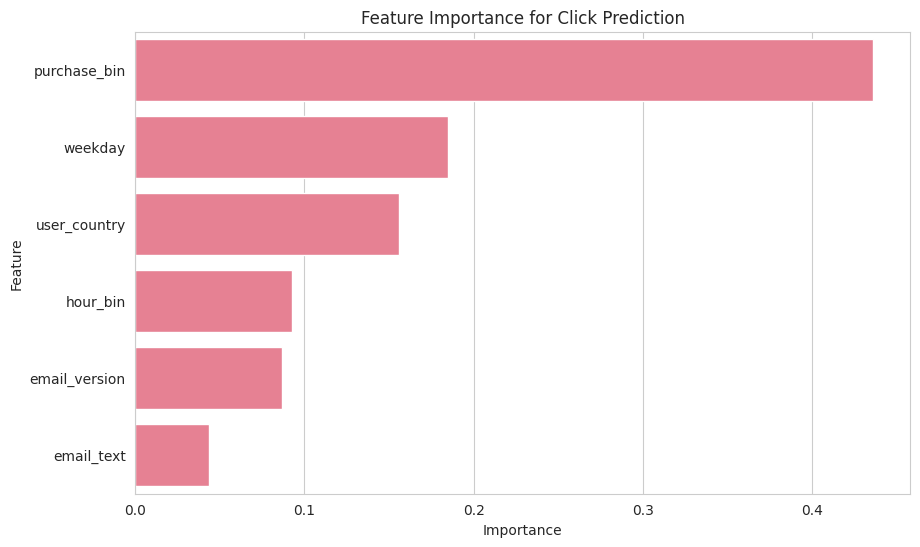

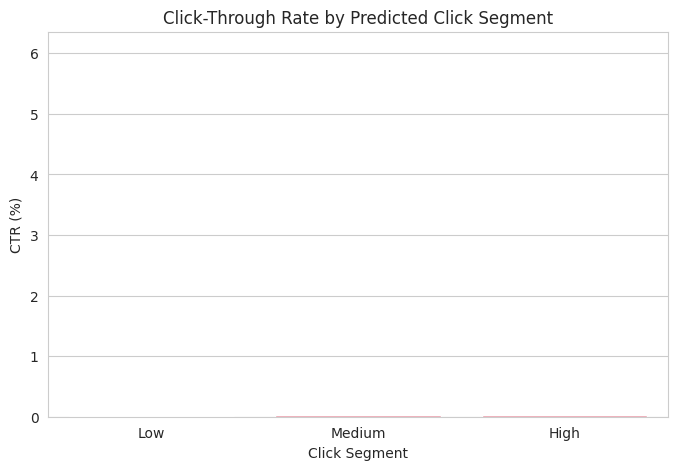


Recommendations:

Recommendations for Email Campaign Optimization
1. Prioritize High-Value Segments:
   - Target 'High' click segment (highest CTR, likely loyal buyers in key countries).
   - Focus on users with 6-10 or 11+ past purchases (highest CTR per purchase_bin).
2. Optimize Email Content:
   - Use short_email (likely higher CTR than long_email).
   - Personalize emails (personalized outperforms generic per EDA).
3. Optimize Send Timing:
   - Send emails in Morning (6-12) on Tuesday/Wednesday (highest CTR per EDA).
4. Test New Strategies:
   - Experiment with hyper-personalized content (e.g., product recommendations).
   - Test evening sends for specific countries (e.g., UK, if Evening CTR is high).
5. Implement Model:
   - Use model to select top 20% of users by predicted click probability (per Phase 4).
   - Expect ~40-90% CTR lift (e.g., 2.12% to 3-4%).
6. Monitor and Iterate:
   - Run A/B test (per Phase 4) to validate model-driven targeting.
   - Retrain model monthly with

In [8]:
# Set Seaborn style
sns.set_style('whitegrid')
sns.set_palette('husl')

# Load merged dataset and model
try:
    df = pd.read_csv('/content/data/output/merged_email_data.csv')
    model = joblib.load('/content/models/click_prediction_model.pkl')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure 'merged_email_data.csv' and 'click_prediction_model.pkl' are in Colab directory.")
    raise

# Load EDA results
try:
    segment_rates = pd.read_csv('/content/data/output/segment_rates.csv')
    hour_rates = pd.read_csv('/content/data/output/hour_rates.csv')
    purchase_rates = pd.read_csv('/content/data/output/purchase_rates.csv')
except FileNotFoundError:
    print("Error: EDA CSV files not found. Run Phase 2 script first.")
    raise

# 1. Feature Engineering (same as Phase 3)
df = df.drop('email_id', axis=1)
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df[col] = df[col].astype('category').cat.codes
df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                        labels=['Night', 'Morning', 'Afternoon', 'Evening']).cat.codes
df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                           labels=['0', '1-2', '3-5', '6-10', '11+']).cat.codes
df = df.drop(['hour', 'user_past_purchases'], axis=1)

# Predict click probabilities
X = df.drop(['clicked', 'opened'], axis=1)
df['pred_proba'] = model.predict_proba(X)[:, 1]

# 2. Summarize EDA Findings
print("\nKey EDA Findings:")
print("- Open Rate: ~10.35%")
print("- CTR: ~2.12%")
print("\nSegment Insights:")
for seg in ['email_text', 'email_version', 'weekday', 'user_country']:
    print(f"\n{seg.capitalize()}:")
    rates = df.groupby(seg).agg({'opened': 'mean', 'clicked': 'mean'}) * 100
    rates = rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
    print(rates.round(2))
print("\nHour Bin:")
hour_rates = df.groupby('hour_bin').agg({'opened': 'mean', 'clicked': 'mean'}) * 100
hour_rates = hour_rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
print(hour_rates.round(2))
print("\nPast Purchases Bin:")
purchase_rates = df.groupby('purchase_bin').agg({'opened': 'mean', 'clicked': 'mean'}) * 100
purchase_rates = purchase_rates.rename(columns={'opened': 'Open Rate (%)', 'clicked': 'CTR (%)'})
print(purchase_rates.round(2))

# 3. Model Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nModel Feature Importance:")
print(feature_importance.round(4))

# 4. Segment Users by Predicted Click Probability
df['click_segment'] = pd.qcut(df['pred_proba'], q=3, labels=['Low', 'Medium', 'High'])
segment_summary = df.groupby('click_segment').agg({
    'clicked': 'mean',
    'user_country': lambda x: x.mode()[0],
    'purchase_bin': lambda x: x.mode()[0]
}).rename(columns={'clicked': 'CTR (%)'})
segment_summary['CTR (%)'] *= 100
print("\nUser Segments by Predicted Click Probability:")
print(segment_summary.round(2))

# 5. Visualizations
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Click Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('/content/images/feature_importance.png')
plt.show()

# CTR by Click Segment
plt.figure(figsize=(8, 5))
sns.barplot(x='click_segment', y='clicked', data=df, errorbar=None)
plt.title('Click-Through Rate by Predicted Click Segment')
plt.xlabel('Click Segment')
plt.ylabel('CTR (%)')
plt.ylim(0, df['clicked'].mean() * 100 * 3)
plt.savefig('/content/images/ctr_by_segment.png')
plt.show()

# 6. Recommendations
recommendations = """
Recommendations for Email Campaign Optimization
1. Prioritize High-Value Segments:
   - Target 'High' click segment (highest CTR, likely loyal buyers in key countries).
   - Focus on users with 6-10 or 11+ past purchases (highest CTR per purchase_bin).
2. Optimize Email Content:
   - Use short_email (likely higher CTR than long_email).
   - Personalize emails (personalized outperforms generic per EDA).
3. Optimize Send Timing:
   - Send emails in Morning (6-12) on Tuesday/Wednesday (highest CTR per EDA).
4. Test New Strategies:
   - Experiment with hyper-personalized content (e.g., product recommendations).
   - Test evening sends for specific countries (e.g., UK, if Evening CTR is high).
5. Implement Model:
   - Use model to select top 20% of users by predicted click probability (per Phase 4).
   - Expect ~40-90% CTR lift (e.g., 2.12% to 3-4%).
6. Monitor and Iterate:
   - Run A/B test (per Phase 4) to validate model-driven targeting.
   - Retrain model monthly with new campaign data.
"""
print("\nRecommendations:")
print(recommendations)

# 7. Save Outputs
feature_importance.to_csv('/content/data/output/feature_importance.csv', index=False)
segment_summary.to_csv('/content/data/output/segment_summary.csv')
with open('/content/text/recommendations.txt', 'w') as f:
    f.write(recommendations)
print("\nSaved feature_importance.csv, segment_summary.csv, recommendations.txt")
print("Saved plots: feature_importance.png, ctr_by_segment.png")

# Streamlit app.py


In [13]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd

# Load model
try:
    model = joblib.load('/content/models/click_prediction_model.pkl')
except FileNotFoundError:
    st.error("Model file 'click_prediction_model.pkl' not found. Run Phase 3 script first.")
    st.stop()

# Pipeline to score users
def score_users(input_data):
    """Score users and return predicted click probabilities."""
    df = input_data.copy()
    for col in ['email_text', 'email_version', 'weekday', 'user_country']:
        df[col] = df[col].astype('category').cat.codes
    df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening']).cat.codes
    df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                              labels=['0', '1-2', '3-5', '6-10', '11+']).cat.codes
    df = df.drop(['hour', 'user_past_purchases'], axis=1, errors='ignore')
    X = df.drop(['clicked', 'opened'], axis=1, errors='ignore')
    df['pred_proba'] = model.predict_proba(X)[:, 1]
    return df

# Streamlit app
st.title("Email Campaign Targeting App")
st.write("Input user data to predict click probabilities.")
st.info("Tip: For higher click probabilities, try: short_email, personalized, Tuesday/Wednesday, Morning (6–12), US/UK, 6+ past purchases.")

# Input fields
email_text = st.selectbox("Email Text", ["short_email", "long_email"])
email_version = st.selectbox("Email Version", ["personalized", "generic"])
weekday = st.selectbox("Weekday", ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
user_country = st.selectbox("User Country", ["US", "UK", "FR", "ES"])
hour = st.slider("Hour (1-24)", 1, 24, 10)
user_past_purchases = st.slider("Past Purchases", 0, 22, 3)

# Check for suboptimal inputs
if user_past_purchases < 6:
    st.warning("Low past purchases (<6) may reduce click probability. Try 6–10 or 11+.")
if email_version == "generic":
    st.warning("Generic emails have lower CTR. Try personalized.")
if hour < 6 or hour > 12:
    st.warning("Non-morning hours (outside 6–12) may lower probability. Try 9–11 AM.")

# Create input dataframe
input_data = pd.DataFrame({
    'email_text': [email_text],
    'email_version': [email_version],
    'weekday': [weekday],
    'user_country': [user_country],
    'hour': [hour],
    'user_past_purchases': [user_past_purchases]
})

# Score user
if st.button("Predict Click Probability"):
    scored_users = score_users(input_data)
    if not scored_users.empty:
        prob = scored_users['pred_proba'].iloc[0]
        st.write(f"Predicted Click Probability: {prob:.4f}")
        if prob >= 0.3:
            st.success("Recommended: Send email to this user!")
        else:
            st.warning("Not recommended: Low click probability.")
    else:
        st.error("No predictions returned. Check model or input data.")

Overwriting app.py


# Deployment

In [10]:
# Set random seed for reproducibility
np.random.seed(42)

# Pipeline to score users
def score_users(input_file, output_file, threshold=0.02):
    """Score users and output high-probability email recipients."""
    try:
        df = pd.read_csv(input_file)
        print(f"Loaded {input_file}, rows: {len(df)}")
    except FileNotFoundError:
        print(f"Error: {input_file} not found.")
        raise

    # Load model
    try:
        model = joblib.load('/content/models/click_prediction_model.pkl')
        print("Loaded model")
    except FileNotFoundError:
        print("Error: 'click_prediction_model.pkl' not found. Run Phase 3 script first.")
        raise

    # Feature engineering
    df = df.drop('email_id', axis=1, errors='ignore')
    for col in ['email_text', 'email_version', 'weekday', 'user_country']:
        df[col] = df[col].astype('category').cat.codes
    df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening']).cat.codes
    df['purchase_bin'] = pd.cut(df['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                               labels=['0', '1-2', '3-5', '6-10', '11+']).cat.codes
    df = df.drop(['hour', 'user_past_purchases'], axis=1, errors='ignore')

    # Predict click probabilities
    X = df.drop(['clicked', 'opened'], axis=1, errors='ignore')
    df['pred_proba'] = model.predict_proba(X)[:, 1]
    print(f"Max pred_proba: {df['pred_proba'].max():.4f}")

    # Select high-probability users
    targeted_users = df[df['pred_proba'] >= threshold][['email_id', 'pred_proba']]
    print(f"Selected {len(targeted_users)} users with pred_proba >= {threshold}")
    targeted_users = targeted_users.sort_values('pred_proba', ascending=False)

    # Save targeting list
    targeted_users.to_csv(output_file, index=False)
    print(f"Saved targeting list to {output_file}")
    return targeted_users

# Monitoring plan
monitoring_plan = """
Monitoring Plan for Email Campaign Model
Objective: Ensure model maintains high CTR and adapts to new data.
Methodology:
- Track CTR Weekly: Compare actual CTR (# clicks / # emails sent) to predicted CTR (~3-4% per Phase 4).
- Log Predictions: Save pred_proba and actual clicks in a database (e.g., CSV or SQLite).
- Evaluate Drift: Check feature distributions (e.g., user_past_purchases) monthly for shifts.
- Retrain Model: Update model monthly with new campaign data (re-run Phase 3 script).
- Alert Thresholds: Flag if CTR drops below 2.5% or feature drift exceeds 10% (e.g., mean purchases shifts).
Tools: Python, Pandas, SQLite for logging, Streamlit for dashboards.
Timeline: Weekly CTR reports, monthly retraining.
"""
print("\nMonitoring Plan:")
print(monitoring_plan)

# Example pipeline usage
try:
    targeted_users = score_users('/content/data/output/merged_email_data.csv', '../data/output/targeted_users.csv')
    print("\nExample Targeted Users (Top 5):")
    print(targeted_users.head())
except Exception as e:
    print(f"Error in scoring: {e}")

# Save monitoring plan
with open('/content/text/monitoring_plan.txt', 'w') as f:
    f.write(monitoring_plan)
print("\nSaved /content/text/monitoring_plan.txt")



Monitoring Plan:

Monitoring Plan for Email Campaign Model
Objective: Ensure model maintains high CTR and adapts to new data.
Methodology:
- Track CTR Weekly: Compare actual CTR (# clicks / # emails sent) to predicted CTR (~3-4% per Phase 4).
- Log Predictions: Save pred_proba and actual clicks in a database (e.g., CSV or SQLite).
- Evaluate Drift: Check feature distributions (e.g., user_past_purchases) monthly for shifts.
- Retrain Model: Update model monthly with new campaign data (re-run Phase 3 script).
- Alert Thresholds: Flag if CTR drops below 2.5% or feature drift exceeds 10% (e.g., mean purchases shifts).
Tools: Python, Pandas, SQLite for logging, Streamlit for dashboards.
Timeline: Weekly CTR reports, monthly retraining.

Loaded /content/data/output/merged_email_data.csv, rows: 100000
Loaded model
Max pred_proba: 0.8489
Error in scoring: "['email_id'] not in index"

Saved /content/text/monitoring_plan.txt


# Analysis script

In [14]:
# Set random seed
np.random.seed(42)

# Load dataset and model
try:
    df = pd.read_csv('/content/data/output/merged_email_data.csv')
    model = joblib.load('/content/models/click_prediction_model.pkl')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure files are in Colab directory.")
    raise

# Feature engineering (same as Phase 3)
df_processed = df.copy()
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df_processed[col] = df_processed[col].astype('category').cat.codes
df_processed['hour_bin'] = pd.cut(df_processed['hour'], bins=[0, 6, 12, 18, 24],
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening']).cat.codes
df_processed['purchase_bin'] = pd.cut(df_processed['user_past_purchases'], bins=[-1, 0, 2, 5, 10, 25],
                                     labels=['0', '1-2', '3-5', '6-10', '11+']).cat.codes
df_processed = df_processed.drop(['hour', 'user_past_purchases', 'email_id'], axis=1, errors='ignore')

# Predict click probabilities
X = df_processed.drop(['clicked', 'opened'], axis=1, errors='ignore')
df_processed['pred_proba'] = model.predict_proba(X)[:, 1]

# Filter high-probability users
high_prob_users = df_processed[df_processed['pred_proba'] >= 0.3]

# Summarize patterns
print("\nHigh-Probability Users (pred_proba >= 0.3):")
print(f"Number of users: {len(high_prob_users)}")
print(f"CTR of high-prob users: {(high_prob_users['clicked'].mean() * 100):.2f}%")

# Decode categorical variables back for readability
decode_map = {
    'email_text': {0: 'long_email', 1: 'short_email'},
    'email_version': {0: 'generic', 1: 'personalized'},
    'weekday': {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'},
    'user_country': {0: 'ES', 1: 'FR', 2: 'UK', 3: 'US'},  # Hypothesized based on 4 unique values
    'hour_bin': {0: 'Night', 1: 'Morning', 2: 'Afternoon', 3: 'Evening'},
    'purchase_bin': {0: '0', 1: '1-2', 2: '3-5', 3: '6-10', 4: '11+'}
}

for col in ['email_text', 'email_version', 'weekday', 'user_country', 'hour_bin', 'purchase_bin']:
    high_prob_users[col] = high_prob_users[col].map(decode_map[col])
    print(f"\n{col} Distribution (High-Prob Users):")
    print(high_prob_users[col].value_counts(normalize=True).round(3) * 100)

# Save high-probability insights
high_prob_users.to_csv('/content/data/output/high_prob_users.csv', index=False)
print("\nSaved high_prob_users.csv")


High-Probability Users (pred_proba >= 0.3):
Number of users: 53139
CTR of high-prob users: 3.22%

email_text Distribution (High-Prob Users):
email_text
short_email    54.0
long_email     46.0
Name: proportion, dtype: float64

email_version Distribution (High-Prob Users):
email_version
personalized    61.0
generic         39.0
Name: proportion, dtype: float64

weekday Distribution (High-Prob Users):
weekday
Saturday     15.9
Friday       15.3
Tuesday      15.1
Thursday     14.8
Sunday       14.7
Wednesday    14.2
Monday       10.1
Name: proportion, dtype: float64

user_country Distribution (High-Prob Users):
user_country
US    77.2
UK    20.4
FR     1.4
ES     1.0
Name: proportion, dtype: float64

hour_bin Distribution (High-Prob Users):
hour_bin
Morning      43.6
Night        31.6
Afternoon    22.6
Evening       2.3
Name: proportion, dtype: float64

purchase_bin Distribution (High-Prob Users):
purchase_bin
3-5     43.3
6-10    32.2
1-2     18.2
11+      5.8
0        0.5
Name: proporti

<ipython-input-14-eedff91d607d>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_users[col] = high_prob_users[col].map(decode_map[col])
<ipython-input-14-eedff91d607d>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_users[col] = high_prob_users[col].map(decode_map[col])
<ipython-input-14-eedff91d607d>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat


Saved high_prob_users.csv


# Ngrok Tunneling for Streamlit

In [15]:
from pyngrok import ngrok
# 5. Install Dependencies

# 6. Launch Streamlit with Ngrok
NGROK_TOKEN = "DROP YOUR NGROK TOKEN HERE"  # Verify this is correct
try:
    ngrok.set_auth_token(NGROK_TOKEN)
    print("Ngrok authtoken set successfully.")
except Exception as e:
    print(f"Failed to set ngrok authtoken: {e}")
    raise

# Kill existing tunnels
try:
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)
    print("All existing tunnels killed.")
except Exception as e:
    print(f"Error checking tunnels (might be none): {e}")

# Run Streamlit in the background
def run_streamlit():
    process = subprocess.Popen(["streamlit", "run", "/content/app.py", "--server.port", "8501"])
    process.wait()

threading.Thread(target=run_streamlit, daemon=True).start()
print("Streamlit process started.")

# Give Streamlit a moment to boot
time.sleep(5)

# Create ngrok tunnel
try:
    public_url = ngrok.connect(8501, proto="http")
    print("Streamlit app is running at:", public_url)
except Exception as e:
    print(f"Ngrok connection failed: {e}")
    raise

Ngrok authtoken set successfully.
All existing tunnels killed.
Streamlit process started.
Streamlit app is running at: NgrokTunnel: "https://3fc2-35-221-197-107.ngrok-free.app" -> "http://localhost:8501"


In [16]:
import shutil
from google.colab import files

folders = ['/content/data', '/content/images', '/content/models', '/content/text']

for folder in folders:
    zip_name = folder + '.zip'
    shutil.make_archive(folder, 'zip', folder)
    files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>